In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Input, layers
from tensorflow.keras import activations
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as k
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# English - Fin

## Training set 

In [2]:
corpus_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/en-fi/scores.csv"
corpus_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/en-fi/laser.reference_embeds.npy"
corpus_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/en-fi/laser.source_embeds.npy"
corpus_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/en-fi/laser.translation_embeds.npy"

In [3]:
corpus_scores = pd.read_csv(corpus_scor)
corpus_reference = np.load(corpus_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_source = np.load(corpus_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_translation = np.load(corpus_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [4]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(corpus_translation,corpus_source.T)

# dot product tranlation reference
h_dot_r = np.dot(corpus_translation,corpus_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(corpus_translation - corpus_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(corpus_translation - corpus_reference)
abs_h_r.shape

train = np.concatenate((corpus_translation,corpus_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_train = np.concatenate((corpus_translation,corpus_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(train.shape,little_train.shape )

(6748, 6748) (6748, 6748)
(6748, 1024) (6748, 1024)
(6748, 17592) (6748, 3072)


In [7]:
test_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/en-fi/scores.csv"
testset_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/en-fi/laser.reference_embeds.npy"
testset_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/en-fi/laser.source_embeds.npy"
testset_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/en-fi/laser.translation_embeds.npy"

In [8]:
test_score = pd.read_csv(test_scor)
testset_reference = np.load(testset_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_source = np.load(testset_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_translation = np.load(testset_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [10]:
testset_reference.shape

(8097, 1024)

In [11]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(testset_translation,testset_source.T)

# dot product tranlation reference
h_dot_r = np.dot(testset_translation,testset_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(testset_translation - testset_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(testset_translation - testset_reference)
abs_h_r.shape

test = np.concatenate((testset_translation,testset_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_test = np.concatenate((testset_translation,testset_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(test.shape,little_test.shape )

(8097, 8097) (8097, 8097)
(8097, 1024) (8097, 1024)
(8097, 20290) (8097, 3072)


# Simple feed forward network

<!-- # LSTM
## Text Classification with RNN - bi-directional 
https://www.tensorflow.org/tutorials/text/text_classification_rnn -->

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [13]:
reference_labels = np.array(corpus_scores['z-score'])
reference_labels.shape

(6748,)

In [14]:
X = little_train
X.shape

(6748, 3072)

In [15]:
Y = reference_labels
Y.shape

(6748,)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(5398, 3072) (5398,)
(1350, 3072) (1350,)


In [17]:
# # X_train = X_train.reshape(-1,1,1024)
# # X_val = X_val.reshape(-1,1,1024)
# # Y_train = Y_train.reshape(-1,1,1)
# # Y_val = Y_val.reshape(-1,1,1)
# # print(X_train.shape,Y_train.shape)
# # print(X_val.shape,Y_val.shape)

# X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

# # Y_train=Y_train.reshape(Y_train.shape[0],Y_train.shape[1],1)

# X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],1)

# Y_val=Y_val.reshape(Y_val.shape[0],Y_val.shape[1],1)

# print(X_train.shape,Y_train.shape)
# print(X_val.shape,Y_val.shape)

In [18]:
# Callbacks
batch_size =10248

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
                              patience=5, min_lr=0.0001)

mcp = ModelCheckpoint('model.h5', 
                      monitor='val_loss', verbose=1, 
                      save_best_only=True, save_weights_only=True)

In [19]:
# model with better results 
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.1))
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation ='relu'))
model.add(Dense(1))

In [20]:
# # Callbacks

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
#                               patience=5, min_lr=0.00001)

# mcp = ModelCheckpoint('model.h5', 
#                       monitor='val_loss', verbose=0, 
#                       save_best_only=True, save_weights_only=True)

# batch_size = 14336

# model = Sequential()

# model.add(Dense(2048, input_shape=(X_train.shape[1],), activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(1024, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(512, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation ='relu'))
# model.add(Dense(1))

In [21]:
model.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['mae'])

In [22]:
print("Fit model on training data")
history = model.fit(
    X_train,
    Y_train,
    epochs=500, # previous 1000
    batch_size =batch_size,# previous one 8192 #4096 - best score so far
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, Y_val),verbose =0, callbacks=[early_stop,reduce_lr]) # validation_split=0.2,mcp

Fit model on training data


(0.0, 2.847943489253521)

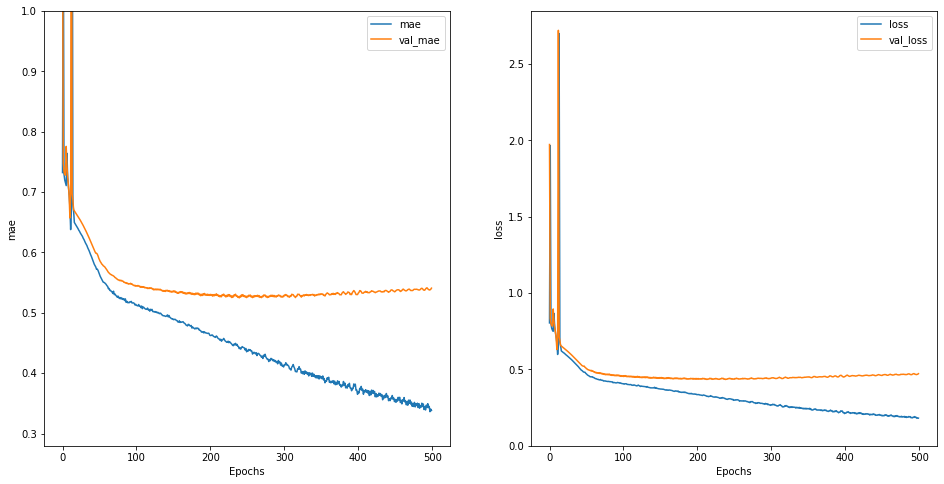

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mae')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
results = model.evaluate(X_val, Y_val, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 500us/step - loss: 0.4723 - mae: 0.5408
test loss, test acc: [0.4722912609577179, 0.5407895445823669]


# predicting @ test data

In [25]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(little_test)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (8097, 1)


In [26]:
test_score['lp'] = 'fi-en'
test_score['score'] = predictions
test_score.head()

,source,reference,translation,lp,score
0,One local resident who did not wish to be name...,"Eräs paikallinen asukas, joka ei halunnut nime...",Toisen nimettömänä pysyttelevän asukkaan mukaa...,fi-en,-1.156435
1,"Still, she clings to a chant she's committed t...",Silti hän takertuu chant hän on sitoutunut mui...,"Silti hän luottaa edelleen iskulauseeseen, jon...",fi-en,-1.170046
2,"I don't want to be asked, 'What were you doing...","En halua, että minulta kysytään: ""Mitä te teit...","En halua, että kenenkään tarvitsee kysyä minul...",fi-en,-1.031639
3,"""I wouldn't say it was a lie – that's a pretty...","""En sanoisi, että se oli valhe - se on aika ro...","En sanoisi, että se oli valhe, se on aika kova...",fi-en,0.651793
4,Kari Kola took part in the opening ceremony of...,Kari Kola osallistui valon vuoden avajaisiin v...,Kari Kola oli mukana Valon teemavuoden avajais...,fi-en,0.245956


In [27]:
test_score.to_csv('fi-en_predictions.csv')

# checking corr @ X_val

In [28]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(X_val)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (1350, 1)


In [29]:
corr_data = pd.DataFrame([Y_val]).T
pred = pd.DataFrame(predictions)
corr_data['predictions'] = pred
corr_data.columns = ['z-score','predictions']
corr_data.corr()

,z-score,predictions
z-score,1.000000,0.692049
predictions,0.692049,1.000000
